<a href="https://colab.research.google.com/github/mattemugno/seai_project/blob/master/GTSRB_classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [ ]:
import os
from google.colab import drive
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from matplotlib.pyplot import imshow
from tensorflow import keras
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random
import cv2
import datetime
import csv
import shutil

In [ ]:
drive.mount('/content/drive/', force_remount=True)
!unzip -q "/content/drive/Shareddrives/seai_project/GTSRB_Final_Training_Images.zip" -d "/content/dataset/"
!unzip -q "/content/drive/Shareddrives/seai_project/GTSRB_Final_Test_Images.zip" -d "/content/dataset_test/"

Mounted at /content/drive/


In [ ]:
training_path = "/content/dataset/GTSRB/Final_Training/Images"
test_path = "/content/dataset_test/GTSRB/Final_Test/Images"
dir_name = "/content/drive/Shareddrives/seai_project/models"

Assign weight to training samples

In [ ]:
entries = []
weights = {i: 0 for i in range(43)}
weights_2 = {}
DATASET_SAMPLES = 39252
x = 0
for path, subdirs, files in os.walk(training_path):
    if not files:
      continue
    weights[x] = DATASET_SAMPLES/(43 * len(os.listdir(path)))
    weights_2[os.path.basename(os.path.normpath(path))] = DATASET_SAMPLES/(43 * len(os.listdir(path)))
    x += 1
    entries += os.listdir(path)
    print("Number of " + os.path.basename(os.path.normpath(path)) + " images: " + str(len(os.listdir(path))))
print("Total number of images: " + str(len(entries)))

Number of 00037 images: 211
Number of 00029 images: 271
Number of 00033 images: 690
Number of 00031 images: 781
Number of 00035 images: 1201
Number of 00005 images: 1861
Number of 00036 images: 391
Number of 00024 images: 271
Number of 00030 images: 451
Number of 00014 images: 781
Number of 00032 images: 241
Number of 00012 images: 2101
Number of 00010 images: 2011
Number of 00026 images: 601
Number of 00006 images: 421
Number of 00040 images: 361
Number of 00016 images: 421
Number of 00022 images: 391
Number of 00008 images: 1411
Number of 00019 images: 211
Number of 00004 images: 1981
Number of 00038 images: 2071
Number of 00023 images: 511
Number of 00018 images: 1201
Number of 00027 images: 241
Number of 00021 images: 331
Number of 00020 images: 361
Number of 00003 images: 1411
Number of 00034 images: 421
Number of 00013 images: 2161
Number of 00017 images: 1111
Number of 00028 images: 541
Number of 00042 images: 241
Number of 00039 images: 301
Number of 00009 images: 1471
Number o

In [ ]:
entries = []
x = 0
for path, subdirs, files in os.walk(test_path):
    if not files:
      continue
    x += 1
    entries += os.listdir(path)
print("Total number of images: " + str(len(entries)))

Total number of images: 12631


In [ ]:
from PIL import Image
images = training_path
data = []; labels = []; classes = 43
for i in range(classes):
    if i < 10:
      img_path = os.path.join(images,"0000" + str(i))
    else:
      img_path = os.path.join(images,"000" + str(i))
    for img in os.listdir(img_path):
        if ".csv" in img:
          continue
        im = Image.open(img_path +'/'+ img)
        im = im.resize((32,32))
        im = np.array(im)
        data.append(im)
        labels.append(i)

data = np.array(data); labels = np.array(labels)

In [ ]:
x = data.astype('float32')
y = keras.utils.to_categorical(np.array(labels))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle=True,stratify=y)

Dimensione del test set

In [ ]:
len(x_test)

3921

#From scratch

##Model dense

In [ ]:
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name, 'GTSRB_model_from_scratch_dense.h5')

callbacks_list = [
    keras.callbacks.EarlyStopping(
      monitor='val_accuracy',
      min_delta=1e-3,
      patience=5,
    ),
    keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True)
]

In [ ]:
input_shape = (32, 32, 3)

num_classes = 43
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(43, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 batch_normalization_1 (Bat  (None, 3072)              12288     
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 300)               921900    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 300)               90300     
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                      

In [ ]:
history = model.fit(x_train, y_train, epochs=200, batch_size=32, validation_split=0.1, callbacks = callbacks_list)

Epoch 1/200
982/993 [============================>.] - ETA: 0s - loss: 2.9844 - accuracy: 0.2208
Epoch 1: val_loss improved from inf to 1.88275, saving model to /content/drive/Shareddrives/seai_project/models/GTSRB_model_from_scratch_dense.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


993/993 [==============================] - 12s 5ms/step - loss: 2.9762 - accuracy: 0.2226 - val_loss: 1.8828 - val_accuracy: 0.5174
Epoch 2/200
988/993 [============================>.] - ETA: 0s - loss: 1.9359 - accuracy: 0.4451
Epoch 2: val_loss improved from 1.88275 to 1.17307, saving model to /content/drive/Shareddrives/seai_project/models/GTSRB_model_from_scratch_dense.h5
993/993 [==============================] - 4s 4ms/step - loss: 1.9347 - accuracy: 0.4453 - val_loss: 1.1731 - val_accuracy: 0.6656
Epoch 3/200
991/993 [============================>.] - ETA: 0s - loss: 1.4497 - accuracy: 0.5666
Epoch 3: val_loss improved from 1.17307 to 0.82046, saving model to /content/drive/Shareddrives/seai_project/models/GTSRB_model_from_scratch_dense.h5
993/993 [==============================] - 4s 4ms/step - loss: 1.4497 - accuracy: 0.5665 - val_loss: 0.8205 - val_accuracy: 0.7645
Epoch 4/200
986/993 [============================>.] - ETA: 0s - loss: 1.1983 - accuracy: 0.6390
Epoch 4: val_lo

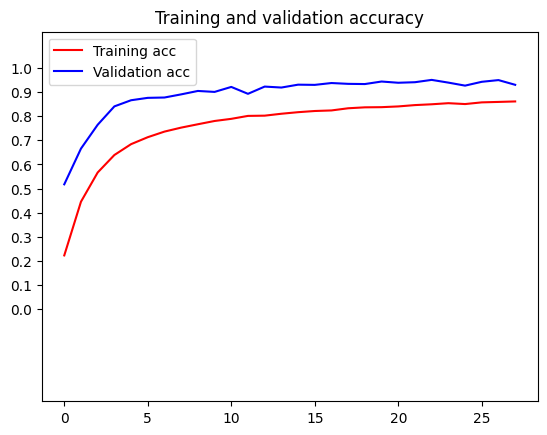

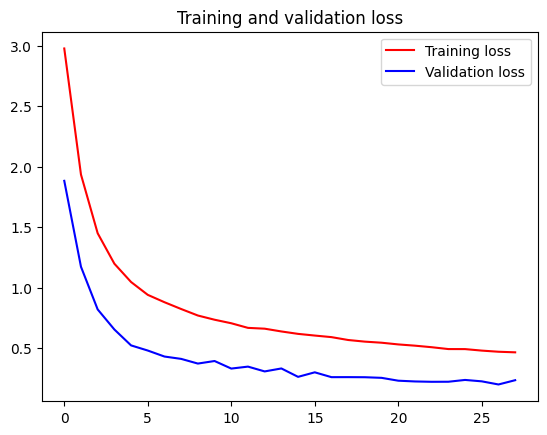

In [ ]:
acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(np.min(acc_1)-0.9, np.max(acc_1)+0.2)
plt.ylim(np.min(val_acc_1)-0.9, np.max(val_acc_1)+0.2)

plt.plot(epochs, acc_1, 'r', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'r', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

123/123 [==============================] - 0s 2ms/step
accuracy: 0.9370058658505483
123/123 [==============================] - 0s 2ms/step - loss: 0.2243 - accuracy: 0.9370
Test accuracy: 0.937, test loss: 0.224
Classification report: 
              precision    recall  f1-score   support

           0     1.0000    0.9524    0.9756        21
           1     0.9762    0.9234    0.9491       222
           2     0.9495    0.9200    0.9345       225
           3     0.9483    0.7801    0.8560       141
           4     0.9208    0.9394    0.9300       198
           5     0.7113    0.9140    0.8000       186
           6     0.9333    1.0000    0.9655        42
           7     0.9512    0.8125    0.8764       144
           8     0.6749    0.9716    0.7965       141
           9     1.0000    0.9456    0.9720       147
          10     0.9947    0.9254    0.9588       201
          11     0.9922    0.9621    0.9769       132
          12     1.0000    0.9905    0.9952       210
       

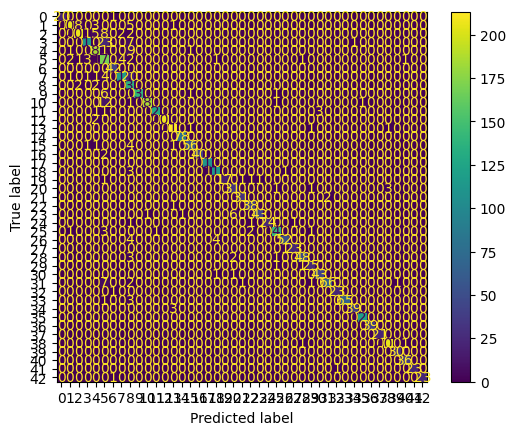

In [ ]:
y_score = model.predict(x_test)
y_pred = np.argmax(y_score, axis=1)
y_true = np.argmax(y_test, axis=1)
correct_predictions = np.sum(np.equal(y_pred, y_true))
accuracy = correct_predictions / len(y_true)
print("accuracy: " + str(accuracy))

test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.3f}, test loss: {test_loss:.3f}")

print("Classification report: ")
print(metrics.classification_report(y_true, y_pred, digits=4))
metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

##Model conv

In [ ]:
dir_name = "/content/drive/Shareddrives/seai_project/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name, 'GTSRB_model_from_scratch_conv.h5')

callbacks_list = [
    keras.callbacks.EarlyStopping(
      monitor='val_accuracy',
      min_delta=1e-3,
      patience=5,
    ),
    keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True)
]

In [ ]:
input_shape = (32, 32, 3)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(43, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten_2 (Flatten)         (None, 1024)             

In [ ]:
history = model.fit(x_train, y_train, epochs=200, batch_size=32, validation_split=0.1, callbacks = callbacks_list)

Epoch 1/200
993/993 [==============================] - ETA: 0s - loss: 3.2381 - accuracy: 0.3182
Epoch 1: val_loss improved from inf to 1.69733, saving model to /content/drive/Shareddrives/seai_project/models/GTSRB_model_from_scratch_conv.h5
993/993 [==============================] - 12s 5ms/step - loss: 3.2381 - accuracy: 0.3182 - val_loss: 1.6973 - val_accuracy: 0.5920
Epoch 2/200
 28/993 [..............................] - ETA: 3s - loss: 1.5875 - accuracy: 0.6217

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


993/993 [==============================] - ETA: 0s - loss: 1.0173 - accuracy: 0.7553
Epoch 2: val_loss improved from 1.69733 to 0.67214, saving model to /content/drive/Shareddrives/seai_project/models/GTSRB_model_from_scratch_conv.h5
993/993 [==============================] - 4s 4ms/step - loss: 1.0173 - accuracy: 0.7553 - val_loss: 0.6721 - val_accuracy: 0.8379
Epoch 3/200
990/993 [============================>.] - ETA: 0s - loss: 0.4626 - accuracy: 0.8887
Epoch 3: val_loss improved from 0.67214 to 0.40058, saving model to /content/drive/Shareddrives/seai_project/models/GTSRB_model_from_scratch_conv.h5
993/993 [==============================] - 5s 5ms/step - loss: 0.4623 - accuracy: 0.8887 - val_loss: 0.4006 - val_accuracy: 0.9011
Epoch 4/200
982/993 [============================>.] - ETA: 0s - loss: 0.2706 - accuracy: 0.9353
Epoch 4: val_loss improved from 0.40058 to 0.31033, saving model to /content/drive/Shareddrives/seai_project/models/GTSRB_model_from_scratch_conv.h5
993/993 [===

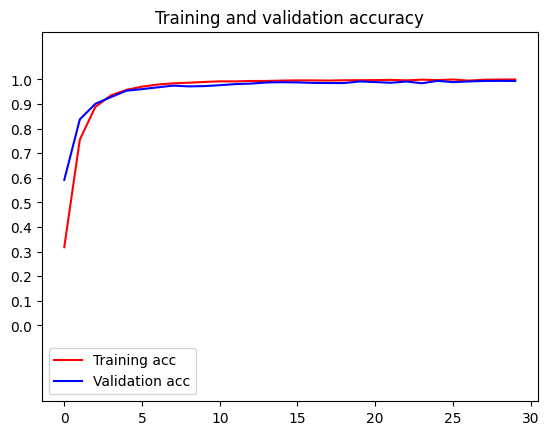

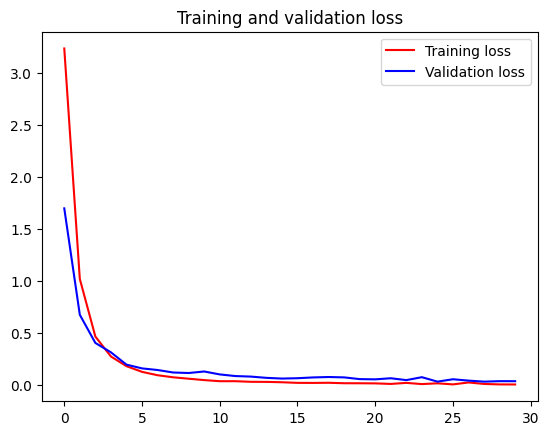

In [ ]:
acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(np.min(acc_1)-0.9, np.max(acc_1)+0.2)
plt.ylim(np.min(val_acc_1)-0.9, np.max(val_acc_1)+0.2)

plt.plot(epochs, acc_1, 'r', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'r', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

123/123 [==============================] - 0s 2ms/step
accuracy: 0.991583779648049
123/123 [==============================] - 0s 2ms/step - loss: 0.0620 - accuracy: 0.9916
Test accuracy: 0.992, test loss: 0.062
Classification report: 
              precision    recall  f1-score   support

           0     1.0000    0.9048    0.9500        21
           1     1.0000    0.9865    0.9932       222
           2     0.9868    0.9956    0.9912       225
           3     0.9722    0.9929    0.9825       141
           4     0.9849    0.9899    0.9874       198
           5     0.9628    0.9731    0.9679       186
           6     1.0000    1.0000    1.0000        42
           7     1.0000    0.9722    0.9859       144
           8     0.9858    0.9858    0.9858       141
           9     0.9932    1.0000    0.9966       147
          10     1.0000    0.9950    0.9975       201
          11     0.9774    0.9848    0.9811       132
          12     1.0000    1.0000    1.0000       210
        

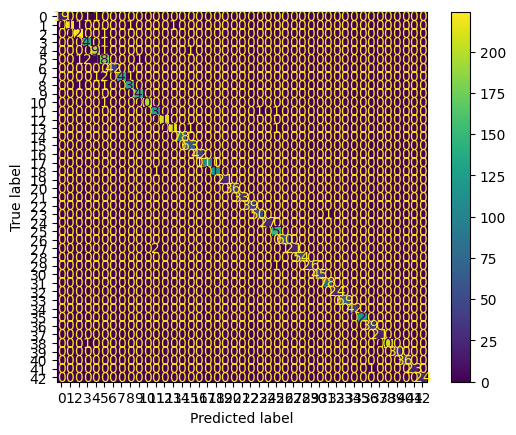

In [ ]:
y_score = model.predict(x_test)
y_pred = np.argmax(y_score, axis=1)
y_true = np.argmax(y_test, axis=1)
correct_predictions = np.sum(np.equal(y_pred, y_true))
accuracy = correct_predictions / len(y_true)
print("accuracy: " + str(accuracy))

test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.3f}, test loss: {test_loss:.3f}")

print("Classification report: ")
print(metrics.classification_report(y_true, y_pred, digits=4))
metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

##Model deeper conv

In [ ]:
dir_name = "/content/drive/Shareddrives/seai_project/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name, 'GTSRB_model_from_scratch_conv_DEEPER.h5')

callbacks_list = [
    keras.callbacks.EarlyStopping(
      monitor='val_accuracy',
      min_delta=1e-3,
      patience=5,
    ),
    keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True)
]

In [ ]:
input_shape = (32, 32, 3)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(43, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 5, 128)         73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 3, 3, 128)        

In [ ]:
history = model.fit(x_train, y_train, epochs=200, batch_size=32, validation_split=0.1, callbacks = callbacks_list)

Epoch 1/200
993/993 [==============================] - ETA: 0s - loss: 1.8206 - accuracy: 0.5521
Epoch 1: val_loss improved from inf to 0.87919, saving model to /content/drive/Shareddrives/seai_project/models/GTSRB_model_from_scratch_conv_DEEPER.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


993/993 [==============================] - 9s 6ms/step - loss: 1.8206 - accuracy: 0.5521 - val_loss: 0.8792 - val_accuracy: 0.7589
Epoch 2/200
991/993 [============================>.] - ETA: 0s - loss: 0.5035 - accuracy: 0.8725
Epoch 2: val_loss improved from 0.87919 to 0.35858, saving model to /content/drive/Shareddrives/seai_project/models/GTSRB_model_from_scratch_conv_DEEPER.h5
993/993 [==============================] - 5s 5ms/step - loss: 0.5030 - accuracy: 0.8726 - val_loss: 0.3586 - val_accuracy: 0.9045
Epoch 3/200
990/993 [============================>.] - ETA: 0s - loss: 0.2386 - accuracy: 0.9429
Epoch 3: val_loss improved from 0.35858 to 0.21681, saving model to /content/drive/Shareddrives/seai_project/models/GTSRB_model_from_scratch_conv_DEEPER.h5
993/993 [==============================] - 5s 5ms/step - loss: 0.2385 - accuracy: 0.9429 - val_loss: 0.2168 - val_accuracy: 0.9476
Epoch 4/200
986/993 [============================>.] - ETA: 0s - loss: 0.1464 - accuracy: 0.9643
Epoc

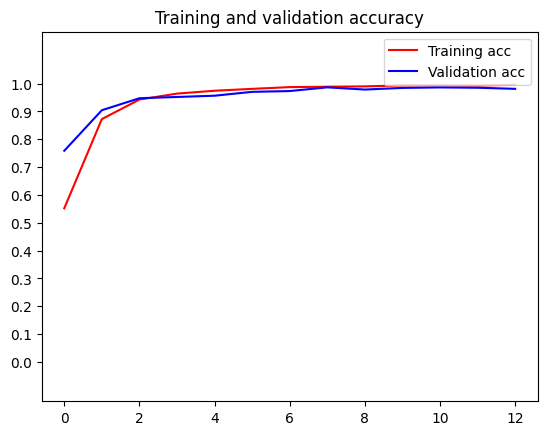

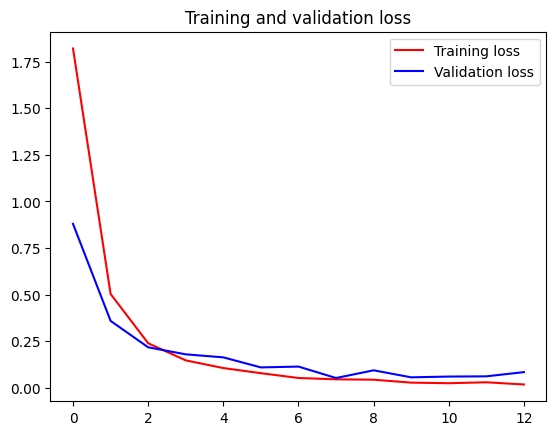

In [ ]:
acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(np.min(acc_1)-0.9, np.max(acc_1)+0.2)
plt.ylim(np.min(val_acc_1)-0.9, np.max(val_acc_1)+0.2)

plt.plot(epochs, acc_1, 'r', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'r', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

123/123 [==============================] - 0s 2ms/step
accuracy: 0.9752614129048712
123/123 [==============================] - 0s 3ms/step - loss: 0.1016 - accuracy: 0.9753
Test accuracy: 0.975, test loss: 0.102
Classification report: 
              precision    recall  f1-score   support

           0     0.9524    0.9524    0.9524        21
           1     0.9953    0.9640    0.9794       222
           2     0.9781    0.9911    0.9845       225
           3     0.8443    1.0000    0.9156       141
           4     0.9897    0.9747    0.9822       198
           5     0.9755    0.8548    0.9112       186
           6     0.9545    1.0000    0.9767        42
           7     0.9857    0.9583    0.9718       144
           8     0.9583    0.9787    0.9684       141
           9     0.9861    0.9660    0.9759       147
          10     1.0000    0.9751    0.9874       201
          11     0.9923    0.9773    0.9847       132
          12     1.0000    1.0000    1.0000       210
       

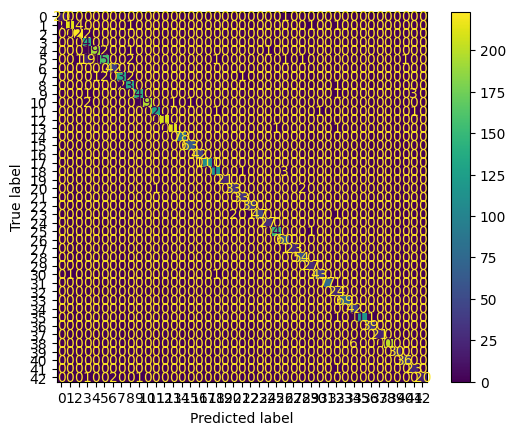

In [ ]:
y_score = model.predict(x_test)
y_pred = np.argmax(y_score, axis=1)
y_true = np.argmax(y_test, axis=1)
correct_predictions = np.sum(np.equal(y_pred, y_true))
accuracy = correct_predictions / len(y_true)
print("accuracy: " + str(accuracy))

test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.3f}, test loss: {test_loss:.3f}")

print("Classification report: ")
print(metrics.classification_report(y_true, y_pred, digits=4))
metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

#Pretrained


In [ ]:
input_shape = (32, 32, 3)

conv_base = keras.applications.resnet_v2.ResNet50V2(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape)
conv_base.trainable = False

num_classes = 43

inputs = keras.Input(shape=input_shape)
x = keras.applications.resnet_v2.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D(name='my_glo_avg_pool')(x)

outputs = layers.Dense(num_classes, activation="softmax", name='predictions')(x)
model = keras.Model(inputs, outputs)

model.summary()

94668760/94668760 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 32, 32, 3)         0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 32, 32, 3)         0         
 da)                                                             
                                                                 
 resnet50v2 (Functional)     (None, 1, 1, 2048)        23564800  
                                                                 
 my_glo_avg_pool (GlobalAve  (None, 2048)              0         
 ragePooling2D)                                               

Fine tuning last two blocks

In [ ]:
conv_base.trainable = True
count = 0
set_trainable = False
for layer in conv_base.layers:
    if '_bn' in layer.name:
        set_trainable = False
    elif 'conv5_block1' in layer.name:
        set_trainable = False
    elif 'conv5_block2' in layer.name:
        set_trainable = True
    elif 'conv5_block3' in layer.name:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 32, 32, 3)         0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 32, 32, 3)         0         
 da)                                                             
                                                                 
 resnet50v2 (Functional)     (None, 1, 1, 2048)        23564800  
                                                                 
 my_glo_avg_pool (GlobalAve  (None, 2048)              0         
 ragePooling2D)                                                  
                                                             

In [ ]:
save_path = os.path.join(dir_name, 'GTSRB_resnet_fine_tuning_2_blocks.h5')

callbacks_list = [
    keras.callbacks.EarlyStopping(
      monitor='val_accuracy',
      min_delta=1e-3,
      patience=5,
    ),
    keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True)
]

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
history= model.fit(x_train, y_train, epochs=200, batch_size=32, validation_split=0.1, callbacks = callbacks_list)

Epoch 1/200
993/993 [==============================] - ETA: 0s - loss: 1.5321 - accuracy: 0.5257
Epoch 1: val_loss improved from inf to 1.05466, saving model to /content/drive/Shareddrives/seai_project/models/GTSRB_resnet_fine_tuning_2_blocks.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


993/993 [==============================] - 18s 13ms/step - loss: 1.5321 - accuracy: 0.5257 - val_loss: 1.0547 - val_accuracy: 0.6588
Epoch 2/200
992/993 [============================>.] - ETA: 0s - loss: 0.7242 - accuracy: 0.7593
Epoch 2: val_loss improved from 1.05466 to 0.70956, saving model to /content/drive/Shareddrives/seai_project/models/GTSRB_resnet_fine_tuning_2_blocks.h5
993/993 [==============================] - 11s 11ms/step - loss: 0.7240 - accuracy: 0.7593 - val_loss: 0.7096 - val_accuracy: 0.7620
Epoch 3/200
989/993 [============================>.] - ETA: 0s - loss: 0.4297 - accuracy: 0.8553
Epoch 3: val_loss improved from 0.70956 to 0.59340, saving model to /content/drive/Shareddrives/seai_project/models/GTSRB_resnet_fine_tuning_2_blocks.h5
993/993 [==============================] - 12s 12ms/step - loss: 0.4299 - accuracy: 0.8553 - val_loss: 0.5934 - val_accuracy: 0.8065
Epoch 4/200
989/993 [============================>.] - ETA: 0s - loss: 0.2886 - accuracy: 0.9003
Epoc

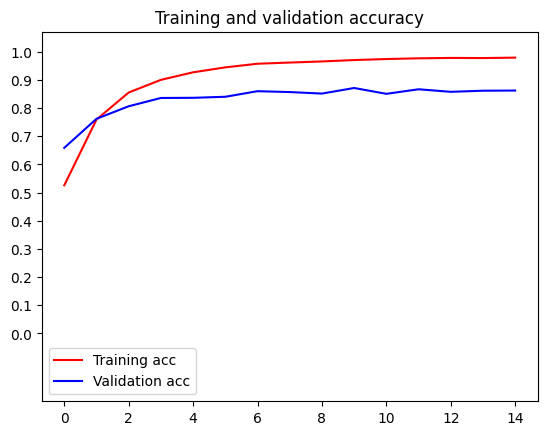

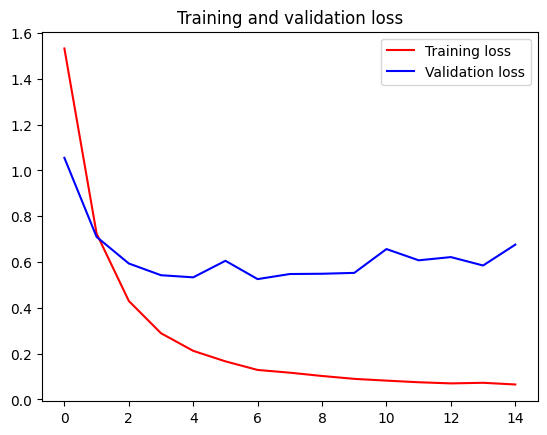

In [ ]:
acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(np.min(acc_1)-0.9, np.max(acc_1)+0.2)
plt.ylim(np.min(val_acc_1)-0.9, np.max(val_acc_1)+0.2)

plt.plot(epochs, acc_1, 'r', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'r', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()